In [1]:
import numpy as np
import os
import sys
sys.path.append("../")

import torch
import torch_geometric

from models.dataset_utils import DataLoader
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

/Users/seiji/.pyenv/versions/3.7.10/envs/empirical/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def feature_extraction(S,X,Label):
    k = max(Label)+1
    M,D = calc_class_features(S,k,Label)
    H = calc_attr_cor(X, Label)

    partition = []
    for i in range(k):
        partition.append([])
    for i in range(len(Label)):
        partition[Label[i]].append(i)

    class_size = []
    for i in partition:
        class_size.append(len(i))
    class_size = np.array(class_size) / sum(class_size)

    # node degree
    theta = np.zeros(len(Label))
    nnz = S.nonzero()
    for i in range(len(nnz[0])):
        if nnz[0][i] < nnz[1][i]:
            theta[nnz[0][i]] += 1
            theta[nnz[1][i]] += 1

    return M,D,list(class_size),H,sorted(theta,reverse=True)

def calc_class_features(S,k,Label):
    pref = np.zeros((len(Label),k))
    nnz = S.nonzero()
    for i in range(len(nnz[0])):
        if nnz[0][i] < nnz[1][i]:
            pref[nnz[0][i]][Label[nnz[1][i]]] += 1
            pref[nnz[1][i]][Label[nnz[0][i]]] += 1
    for i in range(len(Label)):
        pref[i] /= sum(pref[i])
    pref = np.nan_to_num(pref)

    partition = []
    for i in range(k):
        partition.append([])
    for i in range(len(Label)):
        partition[Label[i]].append(i)

    # caluculate average and deviation of class preference
    from statistics import mean, median,variance,stdev
    class_pref_mean = np.zeros((k,k))
    class_pref_dev = np.zeros((k,k))
    for i in range(k):
        pref_tmp = []
        for j in partition[i]:
            pref_tmp.append(pref[j])
        pref_tmp = np.array(pref_tmp).transpose()
        for h in range(k):
            class_pref_mean[i,h] = mean(pref_tmp[h])
            class_pref_dev[i,h] = stdev(pref_tmp[h])
    return class_pref_mean, class_pref_dev

def calc_attr_cor(X, Label):
    k=max(Label)+1
    n=X.shape[0]
    d=X.shape[1]

    partition = []
    for i in range(k):
        partition.append([])
    for i in range(len(Label)):
        partition[Label[i]].append(i)

    from statistics import mean
    attr_cor = np.zeros((d,k))
    for i in range(k):
        tmp=np.zeros(d)
        for j in partition[i]:
            tmp+=X[j]
        attr_cor[:,i] = tmp/len(partition[i])
    return attr_cor


def cpm_cpd_plot(S,Label,wide=None,cpm=True,cpd=True):
    k=max(Label)+1
    import seaborn as sns
    class_pref_mean, class_pref_dev = calc_class_features(S,k,Label)
    if wide == None:
      if cpm:
        plt.rcParams["font.size"] = 13
        plt.title("Class preference mean", fontsize=20)
        hm = sns.heatmap(class_pref_mean,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
        plt.xlabel("class",size=20)
        plt.ylabel("class",size=20)
        plt.tight_layout()
        plt.show()
      if cpd:
        plt.rcParams["font.size"] = 13
        plt.title("Class preference deviation", fontsize=20)
        hm = sns.heatmap(class_pref_dev,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
        plt.xlabel("class",size=20)
        plt.ylabel("class",size=20)
        plt.tight_layout()
        plt.show()
    else:
      plt.subplot(1,3,1)
      plt.rcParams["font.size"] = 10
      plt.title("Class preference mean", fontsize=14)
      hm = sns.heatmap(class_pref_mean,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
      plt.xlabel("class",size=20)
      plt.ylabel("class",size=20)
      # plt.tight_layout()

      plt.subplot(1,3,3)
      plt.rcParams["font.size"] = 10
      plt.title("Class preference deviation", fontsize=14)
      hm = sns.heatmap(class_pref_dev,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
      plt.xlabel("class",size=20)
      plt.ylabel("class",size=20)
      # plt.tight_layout()
      plt.show()
    return class_pref_mean, class_pref_dev

def _load_data(dataset_path, dataset_str):
    import pickle as pkl
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open(dataset_path+"ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(dataset_path+"ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    return adj, features, np.argmax(labels, axis=1)

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

# Output generated graph data in a gml format. 

In [3]:
exp = "classsize"
# exp = "hetero_homo"

data_dir = "../data/GenCAT_Exp_"+exp+"/"

# dataset = 'GenCAT_cora_0.7_0'
dataset = 'GenCAT_cora_0.4_0'
# dataset = 'GenCAT_cora_6_0'

data = DataLoader(dataset, data_dir)[0]
data

Data(x=[2708, 1433], edge_index=[2, 10538], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
from torch_sparse import SparseTensor
n = len(data.y)
tmp = SparseTensor(row=data.edge_index[0], 
                   col=data.edge_index[1], 
                   sparse_sizes=(n,n))
S=tmp.to_dense().numpy()
Label=data.y.numpy()
X=data.x.numpy()

In [5]:
def output_gml(S,Label,tag):
    import datetime
    date=datetime.date.today()
    import networkx as nx
    nodes = np.arange(0,S.shape[0],1)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, cluster={"true":str(Label[i])
                            })
    edges = []
    nonzeros = S.nonzero()
    for i in range(len(nonzeros[0])):
        edges.append((nonzeros[0][i],nonzeros[1][i]))
    G.add_edges_from(edges)
    print(len(G.edges()))
    nx.write_gml(G,"../gml/"+exp+"_"+tag+"_"+str(date)+".gml")

In [6]:
output_gml(S,Label,tag=dataset)

5269


After saving a gml file, we visualize it by using Gephi (https://gephi.org/). 

# Visualizing class preference means

In [7]:
adj, features, labels = _load_data("../data/cora/cora/raw/","cora")
M,D,class_size,H,theta = feature_extraction(adj,features,labels)

In [8]:
def config_class_preference_mean(M,D,x=1):
  import copy
  k = M.shape[0] # number of classes
  M_ = copy.deepcopy(M)
  D_ = copy.deepcopy(D)
  if x != 0:
    for i in range(k): # for each diagonal element
  # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          M_[i][j] -= 0.1 * x
        else:
          M_[i][j] += (0.1 * x) / (k-1)
      M_[M_<0] = 0
    for i in range(k):
    # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]+0.1*x))
        else:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]- (0.1)/(k-1)))
    for i in range(k):
      M_[i] = M_[i] / sum(M_[i])    
    D_[D_<=0] = 0
  return M_, D_

####### beta=0 #######


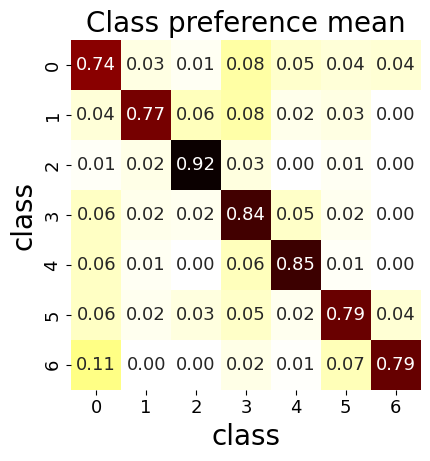

####### beta=1 #######


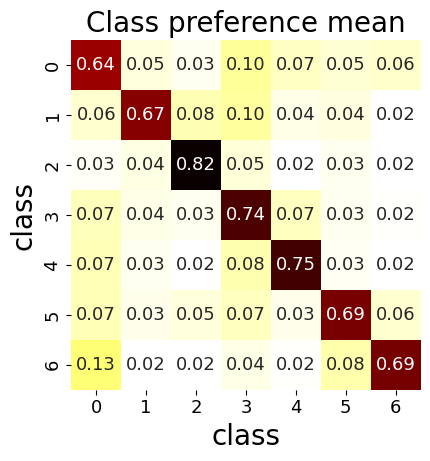

####### beta=2 #######


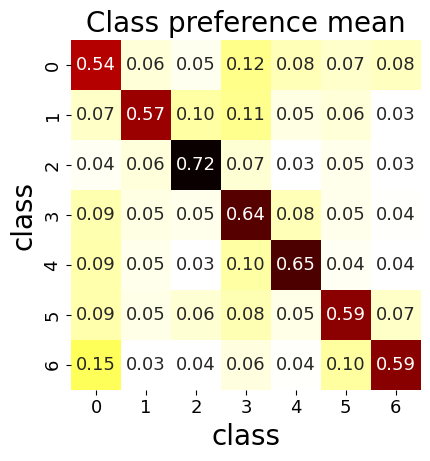

####### beta=3 #######


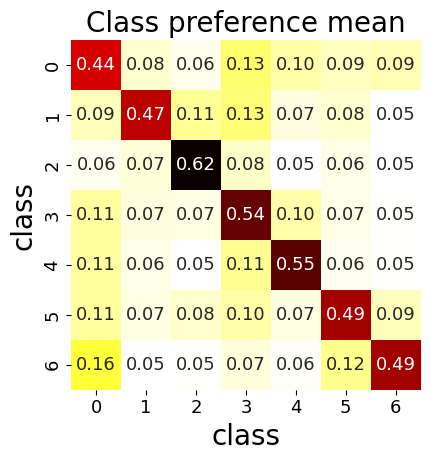

####### beta=4 #######


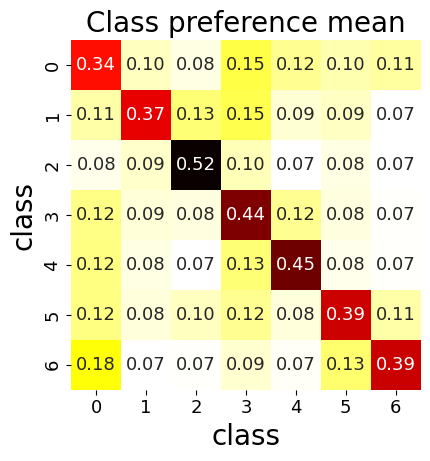

####### beta=5 #######


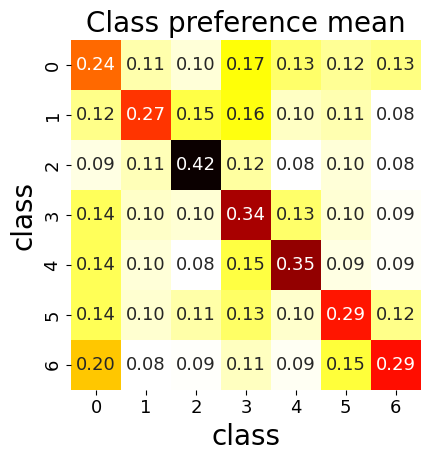

####### beta=6 #######


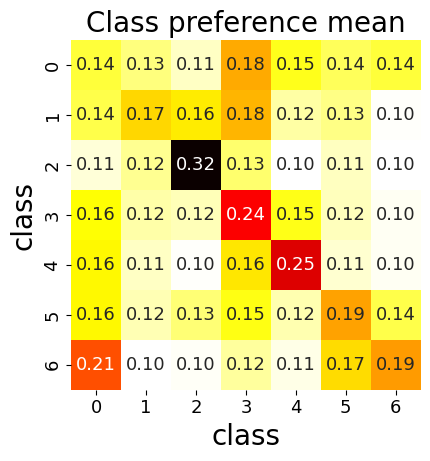

####### beta=7 #######


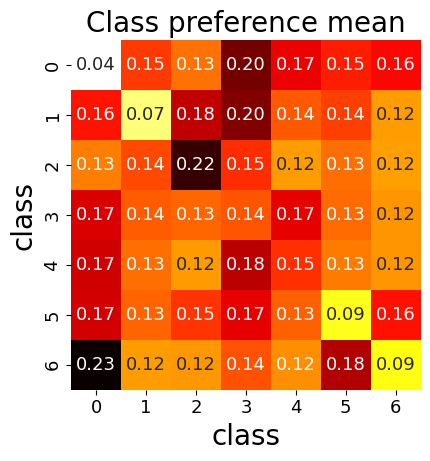

####### beta=8 #######


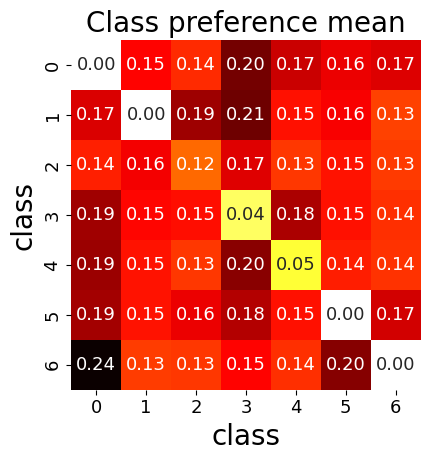

In [9]:
for step in range(9):
  print("####### beta="+str(step)+" #######")
  M_, D_ = config_class_preference_mean(M,D,x=step)
  plt.rcParams["font.size"] = 13
  plt.title("Class preference mean", fontsize=20)
  hm = sns.heatmap(M_,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
  plt.xlabel("class",size=20)
  plt.ylabel("class",size=20)
  plt.tight_layout()
  plt.show()

# Visualizing attributes in 2D.

/Users/seiji/.pyenv/versions/3.7.10/envs/empirical/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


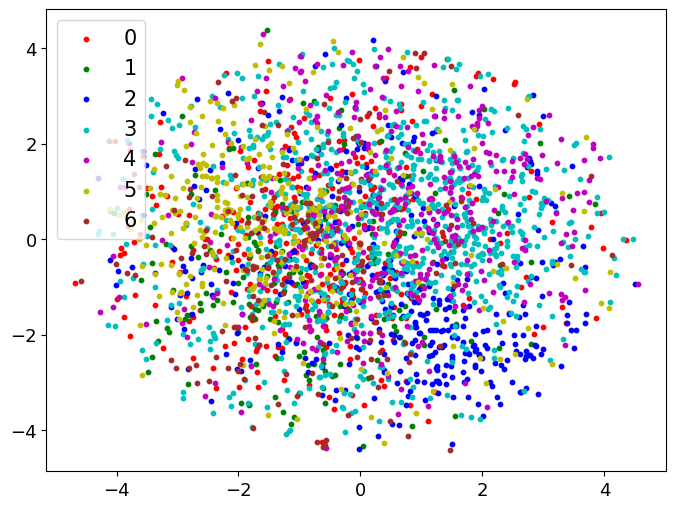

/Users/seiji/.pyenv/versions/3.7.10/envs/empirical/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


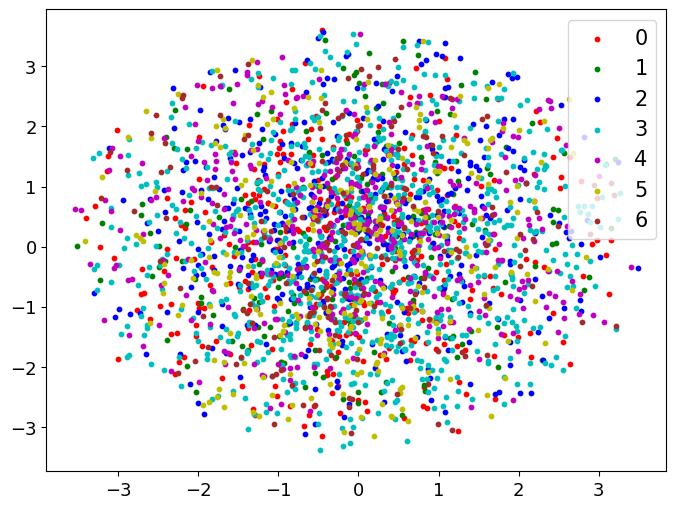

/Users/seiji/.pyenv/versions/3.7.10/envs/empirical/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


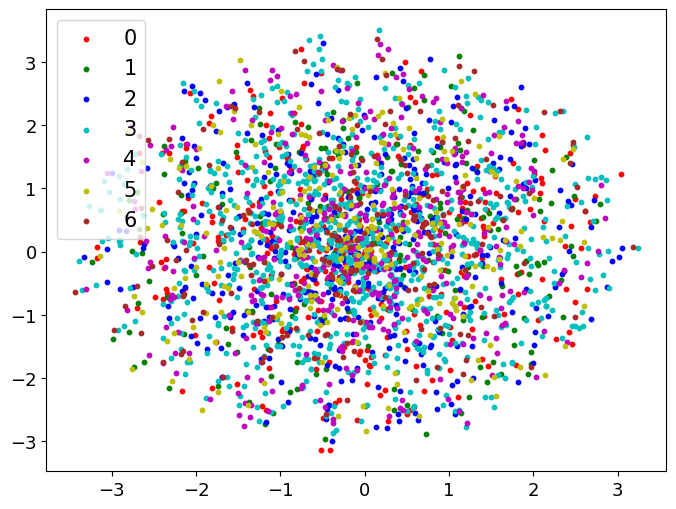

/Users/seiji/.pyenv/versions/3.7.10/envs/empirical/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


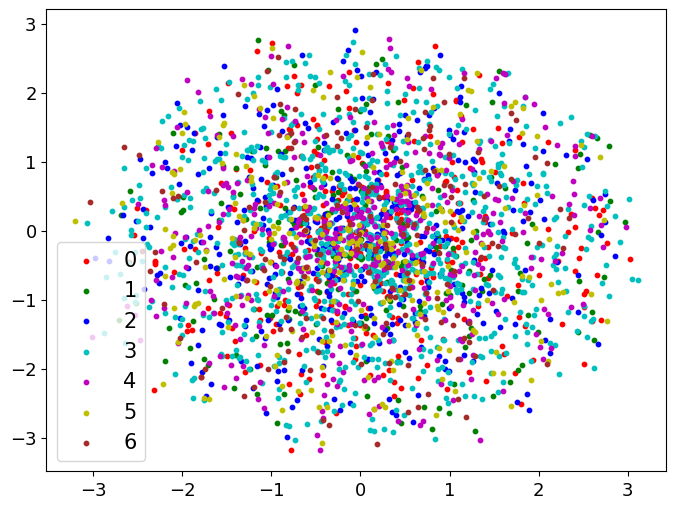

In [10]:
for step in ['0','1','4','16']:
# for step in ['0','4']:
  dataset = 'GenCAT_cora_'+step+'_0'
  if step == '0':
    exp = "hetero_homo"
    # exp = "attribute"
  else:
    exp = "attribute"
  data_dir = "../data/GenCAT_Exp_"+exp+"/"
  data = DataLoader(dataset, data_dir)[0]
  X = data.x.numpy()
  Label=data.y.numpy()

  tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, init = 'random')
  # tsne = TSNE(n_components=2, random_state = 0, perplexity = 40, init = 'pca', learning_rate = 'auto')
  X_embedded = tsne.fit_transform(X)
  ddf = pd.concat([pd.DataFrame(Label), pd.DataFrame(X_embedded, columns = ['col1', 'col2'])], axis = 1)
  article_list = sorted(ddf[0].unique())

  colors =  ["r", "g", "b", "c", "m", "y", "#a52a2a","pink"]
  plt.figure(figsize = (8, 6))
  for i , v in enumerate(article_list):
      tmp_df = ddf[ddf[0] == v]
      plt.scatter(tmp_df['col1'],  
                  tmp_df['col2'],
                  label = v,
                  color = colors[i],
                  marker='o',
                  s=10)

  plt.legend(fontsize = 15)
  plt.show()